### *This file allows to initialize a STG spiking neuron as well as neuromodulating them in a robust way with a controller*

# **Useful packages and functions**

In [1]:
using DifferentialEquations, Plots, Plots.PlotMeasures, LaTeXStrings, Random, Dierckx, DelimitedFiles
using Interpolations
include("STG_kinetics.jl") # Loading of STG kinetics of gating variables
include("STG_models.jl") # Loading of STG model
include("STG_utils.jl") # Loading of some utils functions
include("STG_gs_derivatives.jl") # Loading of X_inf derivatives
include("STG_DIC.jl") # Loading of the DIC and compensation algorithm
include("STG_neuromodulation.jl") # Loading of the neuromodulation cells functions
include("STG_large_simulations.jl"); # Loading of the neuromodulation cells functions

# **Global variables**

In [2]:
# Definition of simulation time (in ms)
const Tfinal = 300000
const tspan  = (0.0, Tfinal)

# Definition of reversal potential values (in mV) and membrane capacitance
const VNa   = 50. # Sodium reversal potential
const VK    = -80. # Potassium reversal potential
const VCa   = 80. # Calcium reversal potential
const VH    = -20. # Reversal potential for the H-current (permeable to both sodium and potassium ions)
const Vleak = -50. # Reversal potential of leak channels
const C     = 1. # Membrane capacitance

# Definition of voltage range for the DICs
const Vmin = -60 
const Vmax = 0
const V    = range(Vmin, stop=Vmax, step=0.01)

# Definition of the number of cells in the random set
const ncells = 200

# Modifying backend GR attributes
gr(guidefontsize=18, legendfontsize=12, margin=5Plots.mm, grid=false)
myApple = RGBA(187/255, 206/255, 131/255, 1)
mySalmon = RGBA(243/255, 124/255, 130/255)
myYellow = RGBA(228/255, 205/255, 121/255, 1)
myBlue = RGBA(131/255, 174/255, 218/255, 1)
myDarkBlue = RGBA(114/255, 119/255, 217/255, 1)
myOrange = RGBA(241/255, 175/255, 113/255, 1)
myPink = RGBA(243/255, 124/255, 130/255, 1)
myPurple = RGBA(169/255, 90/255, 179/255, 1)
myGreen = RGBA(132/255, 195/255, 168/255, 1)
myRed = RGBA(158/255, 3/255, 8/255, 1)
myGray = RGBA(150/255, 150/255, 150/255, 1)
myLightBlue = RGBA(127/255, 154/255, 209/255, 1)
default(fmt = :png)

# Moving average function
moving_average(vs, n, padding) = [sum(vs[i:(i+n-1)])/n for i in 1:padding:(length(vs)-(n-1))];

# **Neuromodulation gCaS and gA overall**

## **Computation of gCaS and gA**

In [3]:
# Fixing random seed
Random.seed!(544)

# Initial firing pattern
guth = 4.
Vth = -50.
(g_all_init, ICs_th_init) = degeneracy_fixDICs_neuromod(ncells, 5., guth, Vth);
# create a spiking set with max variability in gCaS and gA

In [4]:
# Definition of homeostatic parameters
tau_g = 100 # Conductance time constant
tau_Na = 600 # Sodium integral action time constants
Ca_tgt(t) = 125. # Calcium target

# Input current definition
Iapp = 0.

tt = 0. : 0.2 : Tfinal;

In [5]:
gNa_matrix, gCaT_matrix, gCaS_matrix, gA_matrix, gKCa_matrix, gKd_matrix, gH_matrix, 
gleak_matrix, Ca_ma_matrix = simulate_STG_population_beautiful(g_all_init, Iapp, tau_Na, tau_g, Ca_tgt, C,
                                                     ICs_th_init, tt);

Computing... 100%|███████████████████████████████████████| Time: 0:44:37


In [6]:
gA_matrix[gA_matrix .< 1e-10] .= 1e-10;

In [7]:
writedlm("./data/gNa_matrix.dat", gNa_matrix)
writedlm("./data/gCaT_matrix.dat", gCaT_matrix)
writedlm("./data/gCaS_matrix.dat", gCaS_matrix)
writedlm("./data/gA_matrix.dat", gA_matrix)
writedlm("./data/gKCa_matrix.dat", gKCa_matrix)
writedlm("./data/gKd_matrix.dat", gKd_matrix)
writedlm("./data/gH_matrix.dat", gH_matrix)
writedlm("./data/gleak_matrix.dat", gleak_matrix)
writedlm("./data/Ca_ma_matrix.dat", Ca_ma_matrix);

In [7]:
gNa_matrix = readdlm("./data/gNa_matrix.dat")
gCaT_matrix = readdlm("./data/gCaT_matrix.dat")
gCaS_matrix = readdlm("./data/gCaS_matrix.dat")
gA_matrix = readdlm("./data/gA_matrix.dat")
gKCa_matrix = readdlm("./data/gKCa_matrix.dat")
gKd_matrix = readdlm("./data/gKd_matrix.dat")
gH_matrix = readdlm("./data/gH_matrix.dat")
gleak_matrix = readdlm("./data/gleak_matrix.dat")
Ca_ma_matrix = readdlm("./data/Ca_ma_matrix.dat");

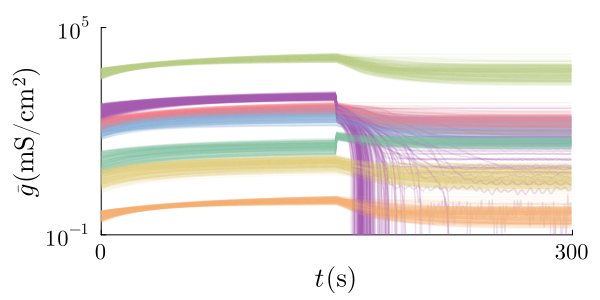

In [13]:
p1 = plot(ylims=(1e-1, 1e5), yticks=([1e-1, 1e5], [L"10^{-1}", L"10^{5}"]), guidefontsize=18,
           xticks=([0, 300], [L"0", L"300"]), tickfontsize=15, size=(600, 300), xlims=(0, 300))

xlabel!(L"t\,\mathrm{(s)}")
ylabel!(L"\bar{g}\,\mathrm{(mS/cm^2)}")

for i = 1 : ncells
    plot!(tt[2:5000:end]./1e3, gNa_matrix[i, :], color=myApple, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gCaT_matrix[i, :], color=myYellow, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gA_matrix[i, :], color=myPurple, linewidth=1.5,
          legend=false, alpha=0.2, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gCaS_matrix[i, :], color=myGreen, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gKCa_matrix[i, :], color=myBlue, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gKd_matrix[i, :], color=myPink, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gH_matrix[i, :], color=myOrange, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
    plot!(tt[2:5000:end]./1e3, gleak_matrix[i, :], color=myDarkBlue, linewidth=1.5,
          legend=false, alpha=0.1, yaxis=:log)
end

display(p1)
# savefig(p1, "./figures/g_all_crash.pdf")